In [5]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import hmean

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, points_extension


from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch
        
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion, save_reconstructions, \
                                           paper_pc_completion_experiment_id_best_epoch
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
GPU = 0

do_training = True
load_model_conf = False
do_evaluation = True
loss = 'chamfer'
max_training_epochs = 100
incomplete_n_samples = 2048
complete_n_samples = 4096


class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]
exp_counter, _ = paper_pc_completion_experiment_id_best_epoch(class_type, loss)

experiment_name = str(exp_counter) + '_' + class_type + '_' + str(incomplete_n_samples) + '_' \
                  + str(complete_n_samples) + 'pts_with_consistency_' + loss

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
complete_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/not_scaled', \
                             str(complete_n_samples), class_syn_id)
    
n_input = [incomplete_n_samples, 3]
n_output = [complete_n_samples, 3]

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/paper_vanilla_vscan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

max_evaluation_epochs = max_training_epochs

Give me the class type.
chair


In [9]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [10]:
cmpl_file_names = pio.load_filenames_of_input_data(complete_pclouds_path, points_extension)
cmpl_pclouds, cmpl_model_names, syn_ids = pio.load_crude_point_clouds(file_names=cmpl_file_names, n_threads=30)
assert(len(np.unique(syn_ids)) == 1)
print '%d files containing complete point clouds were found.' % (len(cmpl_pclouds), )

6778 files containing complete point clouds were found.


In [11]:
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)

if do_training or do_evaluation:
    train_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/train_models_with_scan_id.txt')
    
    train_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id,
                                                      cmpl_pclouds, cmpl_model_names, n_threads=40,
                                                      n_samples=incomplete_n_samples)
    
    train_data, val_data = vscan.make_validation_from_train_data(train_data, 0.10)
    
if do_evaluation:
    test_id_file = osp.join(top_data_dir, 'From_Matthias/train_test_models/test_models_with_scan_id.txt')
    test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id,
                                                      cmpl_pclouds, cmpl_model_names, n_threads=40,
                                                      n_samples=incomplete_n_samples)

30000 incomplete point clouds were loaded.
6000 incomplete point clouds were loaded.


In [13]:
if load_model_conf:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    decoder_args = {'layer_sizes': [1024, np.prod(n_output)],
                    'non_linearity': tf.nn.relu
                   }

    encoder_args = {'dropout_prob': 0.5}
    
    conf = Conf(
                n_input = n_input,
                n_output = n_output,
                denoising = True,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 2,
                learning_rate = 0.0005,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args
               )
    
    conf.consistent_io = 'chamfer'
    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    
reset_tf_graph()
set_visible_GPUs([GPU])
ae = PointNetAutoEncoder(experiment_name, conf)

In [15]:
if do_training:
    training_stats = []
    training_stats.append(ae.train(train_data, conf))    
    with open(osp.join(conf.train_dir, 'train_stats.txt'), 'a') as fout:
        np.savetxt(fout, np.array(training_stats)[0])

('Epoch:', '0001', 'training time (minutes)=', '1.1578', 'loss=', '0.003881522')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/2_chair_2048_4096pts_with_consistency_chamfer/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '1.1635', 'loss=', '0.002433896')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/2_chair_2048_4096pts_with_consistency_chamfer/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0003', 'training time (minutes)=', '1.1208', 'loss=', '0.002105829')
('Epoch:', '0004', 'training time (minutes)=', '1.2790', 'loss=', '0.001909643')
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/paper_vanilla_vscan/2_chair_2048_4096pts_with_consistency_chamfer/models.ckpt-4 is not in all_model_checkpoint_paths. Manually 

In [35]:
if do_evaluation:
   # Pick the epoch that minimizes the loss on the validation dataset.
    saved_epochs = np.array(read_saved_epochs(conf.train_dir))
    allowable_epochs = saved_epochs[saved_epochs <= max_evaluation_epochs]
    val_stats = eval_model(ae, conf, val_data, epochs=allowable_epochs, verbose=True)
    val_loss = np.min(val_stats[:,1])
    best_epoch = int(val_stats[np.argmin(val_stats[:,1]), 0])
    print 'Best epoch = %d.' % (best_epoch,) 
        
    ae.restore_model(conf.train_dir, best_epoch)
#     top_save_dir = osp.join(conf.train_dir, 'output', 'epoch_' + str(best_epoch))
#     save_dir = osp.join(top_save_dir, 'test_predictions')
#     test_recon, test_loss, test_feed, test_ids, test_gt = ae.evaluate(test_data, conf)
#     save_reconstructions(save_dir, test_recon, test_gt, test_feed, test_ids) # save ply files of test data.    
#     train_loss = ae.evaluate(train_data, conf)[1]

    test_gt, test_ids, test_feed = test_data.full_epoch_data()
    n_examples = len(test_feed)
    
    test_recon = np.zeros([n_examples] + ae.n_output)
    b = conf.batch_size
    for i in xrange(0, n_examples, b):
        test_recon[i:i + b] = ae.sess.run((ae.x_reconstr), feed_dict={ae.x: test_feed[i:i + b]})
            
    # Report Accuracy and Coverage of test data.    
    pred_scores = np.zeros((n_examples, 2))
    for i in xrange(n_examples):
        gt = test_gt[i]
        pred = test_recon[i]    
        pred_scores[i, 0] = accuracy_of_completion(pred, gt, thres=0.02, ret_dists=False)
        pred_scores[i, 1] = coverage_of_completion(gt, pred, thres=0.02, ret_dists=False)
    
    print 'Test Median-Accuracy-Coverage:', np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])
    print 'Test Median H-Measure:',  np.median(hmean(pred_scores, 1))

    with open(osp.join(top_save_dir, 'stats.txt'), 'w') as fout:
        fout.write('Best Validation Epoch = %d\n' % (best_epoch))
        fout.write('Validation loss = %f\n' % (val_loss))
        fout.write('Train loss = %f\n' % (train_loss))
        fout.write('Test loss = %f\n' % (test_loss))
        fout.write('Gen. Error (abs, per) = %f %f\n' % (abs(test_loss-train_loss),  abs(test_loss-train_loss) / train_loss ))
        fout.write('Test Median-Accuracy-Coverage = %f %f\n' % (np.median(pred_scores[:, 0]), np.median(pred_scores[:, 1])))
        fout.write('Test Median Harmonic Mean = %f' % (np.median(hmean(pred_scores, 1))))

Model restored in epoch 1.
[ 0.0026677]
Model restored in epoch 2.
[ 0.00227787]
Model restored in epoch 4.
[ 0.00191942]
Model restored in epoch 6.
[ 0.00176782]
Model restored in epoch 8.
[ 0.00168763]
Model restored in epoch 10.
[ 0.00162943]
Model restored in epoch 12.
[ 0.00156618]
Model restored in epoch 14.
[ 0.00155587]
Model restored in epoch 16.
[ 0.00149995]
Model restored in epoch 18.
[ 0.00148466]
Model restored in epoch 20.
[ 0.00149432]
Model restored in epoch 22.
[ 0.00142977]
Model restored in epoch 24.
[ 0.00144418]
Model restored in epoch 26.
[ 0.00142708]
Model restored in epoch 28.
[ 0.00141745]
Model restored in epoch 30.
[ 0.0013955]
Model restored in epoch 32.
[ 0.00143134]
Model restored in epoch 34.
[ 0.0013948]
Model restored in epoch 36.
[ 0.00138372]
Model restored in epoch 38.
[ 0.00137175]
Model restored in epoch 40.
[ 0.00137313]
Model restored in epoch 42.
[ 0.00136882]
Model restored in epoch 44.
[ 0.00136452]
Model restored in epoch 46.
[ 0.00134998]


NameError: name 'top_save_dir' is not defined

['03001627.c1e8b1bd34874c83febad4f49b26ec52.__2__']


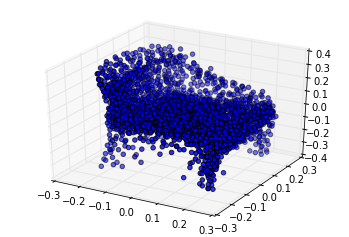

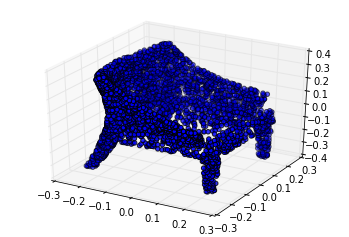

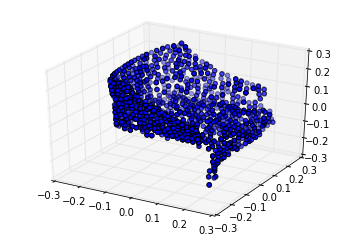

In [34]:
complete, idf, feed = test_data.next_batch(1)
print idf
pred = ae.sess.run(ae.x_reconstr, feed_dict={ae.x:feed})
Point_Cloud(points=np.squeeze(pred)).plot();
Point_Cloud(points=np.squeeze(complete)).plot();
Point_Cloud(points=np.squeeze(feed)).plot();

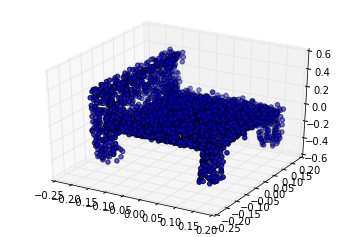

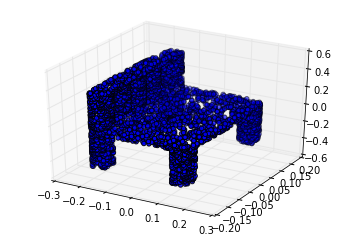

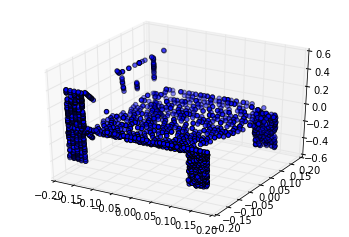

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


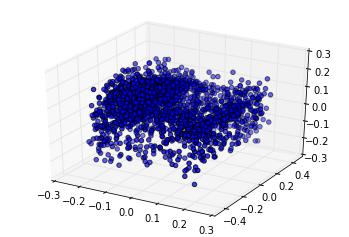

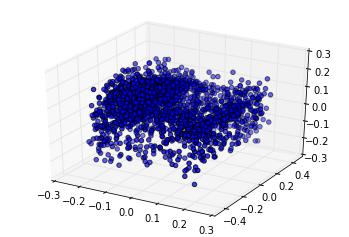